In [612]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys 
import torch

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.decomposition import PCA

plt.style.use('../jmlr.mplstyle')

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from minPCA.minpca import minPCA, get_errs_pca, get_vars_pca, generate_params
from maxMC.setup import random_cov
from minpca_simulations.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utils -- reworked

1. Sampling from the convex hull of covariance matrices. Is it uniform? Not exactly. But we do the best we can:
    * We sample uniformly from the simple $\Delta_E$ and then construct the test $\Sigma$ with these weights.
    * See [this blog](http://blog.geomblog.org/2005/10/sampling-from-simplex.html) or this [stack overflow](https://cs.stackexchange.com/questions/3227/uniform-sampling-from-a-simplex): normalized exponential distribution samples uniformly from simplex

2. Generating random covariates:
    * Shared and env-specific components are orthogonal
    * All $\Sigma_e$ share the same eigenvalues, only the directions of the environment-specific components change.


In [615]:
def sample_from_convex_hull2(item_list, n_samples):
    """
    For n_samples times:
    Sample a point uniformly in the E:=len(item_list)-dimensional simplex,
    then return the corresponding convex combination of the items in item_list.
    """
    item_list = np.asarray(item_list)
    n_items = item_list.shape[0]
    samples = []

    for i in range(n_samples):
        weights = np.random.gamma(shape=1.0, scale=1.0, size=n_items) # Exp(1)
        weights /= weights.sum()
        samples.append(np.sum([w * item for w, item in zip(weights, item_list)], axis=0))

    return samples

In [614]:
def get_random_covs(p, rank, nenvs, 
                    a1=0.1, b1=0.9, a2=0.1, b2=0.9, 
                    full_cov=True):
    """
    Generate nenvs random covariance matrices of size pxp
    with rank `rank` shared component and rank `rank` env-specific component.
    Eigenvalues of shared and env-specific components are preserved exactly.

    Input
    p : the size of the covariance matrix
    rank : the rank of the covariance matrix
    nenvs : number of environments
    a1 : the lower bound for the eigenvalues of the shared component
    b1 : the upper bound for the eigenvalues of the shared component
    a2: the lower bound for the eigenvalues of the env-specific component
    b2 : the upper bound for the eigenvalues of the env-specific component
    full_cov : if True, return the full covariance matrix
                otherwise, return the eigenvalues and the orthogonal matrix
    """
    assert full_cov, "This function only supports full_cov=True for now."
    
    covs = []

    # 1. Generate shared eigenvalues
    eigvals_shared = np.random.uniform(a1, b1, rank)
    
    # 2. Generate env-specific eigenvalues
    eigvals_env = np.random.uniform(a2, b2, rank)
    
    for _ in range(nenvs):
        # 3. Shared random orthonormal basis
        Q0, _ = np.linalg.qr(np.random.randn(p, rank))
        
        # 4. Environment-specific orthonormal basis, orthogonal to Q0
        Qi = np.random.randn(p, rank)
        # Make orthogonal to Q0
        Qi -= Q0 @ (Q0.T @ Qi)
        # Orthonormalize
        Qi, _ = np.linalg.qr(Qi)
        
        # 5. Stack into single orthonormal basis
        Qtilde = np.concatenate([Q0, Qi], axis=1)  # p x 2*rank
        Lambda_tilde = np.diag(np.concatenate([eigvals_shared, eigvals_env]))
        
        # 6. Construct covariance
        C = Qtilde @ Lambda_tilde @ Qtilde.T
        covs.append(C)
        
    return [C / np.linalg.trace(C) for C in covs]


# 0. Which seed for viz?

all eigvals: [0.1757 0.2967 0.3233 0.4109 0.4767 0.5052 0.5669 0.5711 0.7479 0.7509]
	improving from 0.417 to 0.419
	improving from 0.419 to 0.419
	improving from 0.419 to 0.420
	improving from 0.420 to 0.420
	improving from 0.420 to 0.421


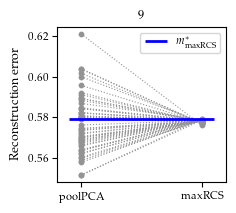

all eigvals: [0.1352 0.422  0.534  0.5958 0.618  0.6473 0.6738 0.6907 0.7653 0.8935]
	improving from 0.403 to 0.403
	improving from 0.403 to 0.404
	improving from 0.404 to 0.404


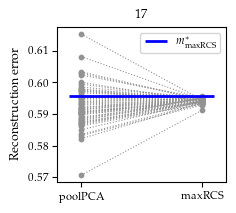

all eigvals: [0.2887 0.6917 0.6968 0.7129 0.7676 0.8677 0.9039 0.9073 0.934  0.9815]
	improving from 0.389 to 0.390
	improving from 0.390 to 0.390
	improving from 0.390 to 0.390


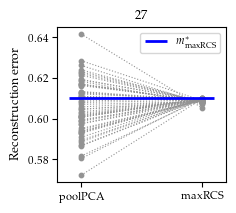

all eigvals: [0.2644 0.5599 0.5625 0.6988 0.7806 0.8645 0.8682 0.8907 0.9598 0.9858]


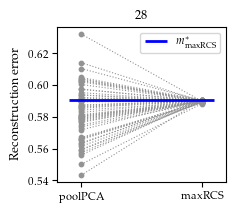

all eigvals: [0.5366 0.5881 0.6425 0.7264 0.754  0.7598 0.7914 0.864  0.8816 0.9319]
	improving from 0.392 to 0.392
	improving from 0.392 to 0.392


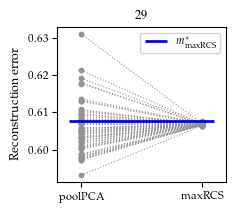

In [ ]:
for seed in [9,17,27,28,29]:
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Parameters for the first simulation
    p1 = 20
    n_components1 = 5
    n_envs1 = 5
    n_test_envs1 = 50 # Number of test environments to sample from the convex hull

    # Generate training and test covariances for the first simulation
    mu1 = np.zeros(p1)
    training_covs1 = get_random_covs(p1, n_components1, n_envs1, 
                                    a1=0.5, b1=1.0, a2=0.1, b2=1.0, 
                                    full_cov=True)
    avg_cov1 = np.mean(training_covs1, axis=0)
    test_covs1 = training_covs1 + sample_from_convex_hull2(training_covs1, n_test_envs1)

    # svd of the average covariance (ie population poolPCA solution)
    U1, S1, V1_T = np.linalg.svd(avg_cov1)
    vpca1 = torch.tensor(V1_T.T[:, :n_components1]).float()

    # minPCA solution
    minpca1 = minPCA(n_components=n_components1, norm=True) 
    minpca1 = minpca1.fit(training_covs1, from_cov=True, n_restarts=20, 
                        lr=0.1, n_iters=1000) 
    vminpca1 = minpca1.v_ #.detach().numpy()

    out = []
    for i, test_cov in enumerate(test_covs1):
        params = generate_params([test_cov], from_cov=True)
        out.append({
            'var_pool': get_vars_pca(vpca1, params)[0],
            'var_minpca':  get_vars_pca(vminpca1, params)[0],
            'i': i,
        })

    out_df = pd.DataFrame(out)
    out_df.tail()   

    plt.figure(figsize=(2.4,2))
    for row in out_df.itertuples():
        plt.scatter(
                # [r'$\mathtt{PCA}$', r'$\mathtt{norm-maxRCS}$'], 
                ['poolPCA', 'maxRCS'],
                [1-row.var_pool, 1-row.var_minpca], 
                s=10,
                marker='o', c='#939393')
        plt.plot(
            # [r'$\mathtt{PCA}$', r'$\mathtt{norm-maxRCS}$'], 
            ['poolPCA', 'maxRCS'],
                [1-row.var_pool, 1-row.var_minpca], 
                ':', linewidth=0.8, #alpha=0.8,
                c='#939393')
    plt.hlines(1-minpca1.minvar(), xmin=-0.1, xmax=1.1, linestyle='-',
            linewidth=2,
            color='blue', label = r'$m^*_\text{maxRCS}$')
    plt.ylabel('Reconstruction error')
    plt.legend(loc='upper right')
    plt.xlim(-0.2, 1.2)
    plt.tight_layout()
    plt.title(seed)
    # plt.savefig('figs/sim_maxrcs_bound.png', dpi=400)
    plt.show()

# 1. Viz theoretical result

In [584]:
SEED1 = 17 #9,17,27,28,29

In [585]:
np.random.seed(SEED1)
torch.manual_seed(SEED1)

# Parameters for the first simulation
p1 = 20
n_components1 = 5
n_envs1 = 5
n_test_envs1 = 50 # Number of test environments to sample from the convex hull

# Generate training and test covariances for the first simulation
mu1 = np.zeros(p1)
training_covs1 = get_random_covs(p1, n_components1, n_envs1, 
                                 a1=0.5, b1=1.0, a2=0.1, b2=1.0, 
                                 full_cov=True)
avg_cov1 = np.mean(training_covs1, axis=0)
test_covs1 = training_covs1 + sample_from_convex_hull2(training_covs1, n_test_envs1)

In [586]:
print(np.linalg.trace(training_covs1[0]))
print(np.linalg.matrix_rank(training_covs1[0]))
eigvals1, _ = np.linalg.eigh(training_covs1[0])
print("Rounded eigvals after:", np.sort(eigvals1.round(4)[-2*n_components1:]))

1.0
10
Rounded eigvals after: [0.0226 0.0706 0.0894 0.0997 0.1034 0.1083 0.1128 0.1156 0.1281 0.1495]


In [587]:
# print(np.linalg.trace(training_covs1[0]))
# print(np.linalg.matrix_rank(training_covs1[0]))
# eigvals1, _ = np.linalg.eigh(training_covs1[0])
# for i in range(n_envs1):
#     eigvals, Q = np.linalg.eigh(training_covs1[i])
#     print(f"Env {i}: rank {np.linalg.matrix_rank(training_covs1[i])}")
#     assert np.allclose(eigvals, eigvals1)

## 1.1. get solutions

In [588]:
# svd of the average covariance (ie population poolPCA solution)
U1, S1, V1_T = np.linalg.svd(avg_cov1)
vpca1 = torch.tensor(V1_T.T[:, :n_components1]).float()

In [589]:
# minPCA solution
minpca1 = minPCA(n_components=n_components1, norm=True) 
minpca1 = minpca1.fit(training_covs1, from_cov=True, n_restarts=20, 
                      lr=0.1, n_iters=1000) 
vminpca1 = minpca1.v_ #.detach().numpy()

	improving from 0.403 to 0.403
	improving from 0.403 to 0.404
	improving from 0.404 to 0.404


In [590]:
# minPCA solution
minpca2 = minPCA(n_components=n_components1, norm=False) 
minpca2 = minpca2.fit(training_covs1, from_cov=True, n_restarts=20, 
                      lr=0.1, n_iters=1000) 
vminpca2 = minpca2.v_ #.detach().numpy()

	improving from 0.402 to 0.403
	improving from 0.403 to 0.403
	improving from 0.403 to 0.405


## 1.2. sample more environments: get reconstruction error

In [591]:
out = []
for i, test_cov in enumerate(test_covs1):
    params = generate_params([test_cov], from_cov=True)
    out.append({
        'var_pool': get_vars_pca(vpca1, params)[0],
        'var_minpca':  get_vars_pca(vminpca1, params)[0],
        'i': i,
    })

In [592]:
out_df = pd.DataFrame(out)
out_df.tail()

,var_pool,var_minpca,i
50,0.402254,0.405333,50
51,0.417811,0.406576,51
52,0.412863,0.407063,52
53,0.399996,0.406097,53
54,0.402548,0.405466,54


## 1.3. plot

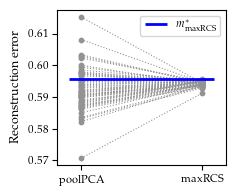

In [616]:
plt.figure(figsize=(2.4,2))
for row in out_df.itertuples():
    plt.scatter(
            # [r'$\mathtt{PCA}$', r'$\mathtt{norm-maxRCS}$'], 
            ['poolPCA', 'maxRCS'],
             [1-row.var_pool, 1-row.var_minpca], 
             s=10,
             marker='o', c='#939393')
    plt.plot(
        # [r'$\mathtt{PCA}$', r'$\mathtt{norm-maxRCS}$'], 
        ['poolPCA', 'maxRCS'],
             [1-row.var_pool, 1-row.var_minpca], 
             ':', linewidth=0.8, #alpha=0.8,
              c='#939393')
plt.hlines(1-minpca1.minvar(), xmin=-0.1, xmax=1.1, linestyle='-',
           linewidth=2,
           color='blue', label = r'$m^*_\text{maxRCS}$')
plt.ylabel('Reconstruction error')
plt.legend(loc='upper right')
plt.xlim(-0.2, 1.2)
plt.tight_layout()
plt.savefig('figs_1026/sim_maxrcs_bound.png', dpi=400)
plt.show()

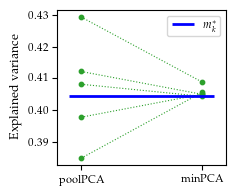

In [594]:
plt.figure(figsize=(2.4,2))
for row in out_df[:5].itertuples():
    plt.scatter(
            # [r'$\mathtt{PCA}$', r'$\mathtt{norm-maxRCS}$'], 
            ['poolPCA', 'minPCA'],
             [row.var_pool, row.var_minpca], 
             s=10,
             marker='o', c='tab:green')
    plt.plot(
        # [r'$\mathtt{PCA}$', r'$\mathtt{norm-maxRCS}$'], 
        ['poolPCA', 'minPCA'],
             [row.var_pool, row.var_minpca], 
             ':', linewidth=0.8, #alpha=0.8,
              c='tab:green')
plt.hlines(minpca1.minvar(), xmin=-0.1, xmax=1.1, linestyle='-',
           linewidth=2,
           color='blue', label = r'$m^*_k$')
plt.ylabel('Explained variance')
plt.legend(loc='upper right')
plt.xlim(-0.2, 1.2)
plt.tight_layout()
# plt.savefig('figs/sim_maxrcs_bound_source_B.png', dpi=600)
plt.show()

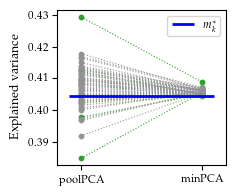

In [595]:
plt.figure(figsize=(2.4,2))
for i,row in enumerate(out_df.itertuples()):
    color = 'tab:green' if i<5 else '#939393'
    plt.scatter(
            # [r'$\mathtt{PCA}$', r'$\mathtt{norm-maxRCS}$'], 
            ['poolPCA', 'minPCA'],
             [row.var_pool, row.var_minpca], 
             s=10,
             marker='o', c=color)
    plt.plot(
        # [r'$\mathtt{PCA}$', r'$\mathtt{norm-maxRCS}$'], 
        ['poolPCA', 'minPCA'],
             [row.var_pool, row.var_minpca], 
             ':', linewidth=0.8, #alpha=0.8,
              c=color)
plt.hlines(minpca1.minvar(), xmin=-0.1, xmax=1.1, linestyle='-',
           linewidth=2,
           color='blue', label = r'$m^*_k$')
plt.ylabel('Explained variance')
plt.legend(loc='upper right')
plt.xlim(-0.2, 1.2)
plt.tight_layout()
# plt.savefig('figs/sim_maxrcs_bound_source_target.png', dpi=600)
plt.show()

## 1.4. double-check the other objectives have the same solution

In [577]:
# minPCA solution
minpca3 = minPCA(n_components=n_components1, norm=True, function='maxreconstruction') 
minpca3 = minpca3.fit(training_covs1, from_cov=True, n_restarts=20,
                      lr=0.1, n_iters=500) 
minpca3 = minpca3.v_ #.detach().numpy()

	improving from 0.403 to 0.404


In [578]:
# minPCA solution
minpca4 = minPCA(n_components=n_components1, norm=True, function='regret_variance') 
minpca4 = minpca4.fit(training_covs1, from_cov=True, n_restarts=20,
                      lr=0.1, n_iters=500) 
minpca4 = minpca4.v_ #.detach().numpy()

	improving from 0.402 to 0.405


In [579]:
# minPCA solution
minpca5 = minPCA(n_components=n_components1, norm=False, function='regret_variance') 
minpca5 = minpca5.fit(training_covs1, from_cov=True, n_restarts=20,
                      lr=0.1, n_iters=500) 
minpca5 = minpca5.v_ #.detach().numpy()

	improving from 0.398 to 0.403
	improving from 0.403 to 0.405


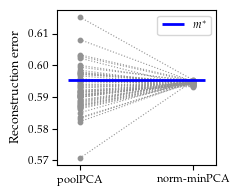

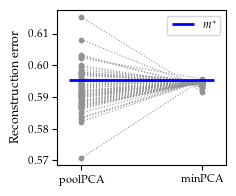

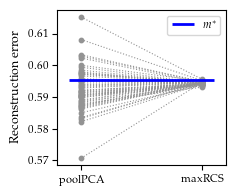

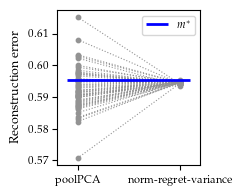

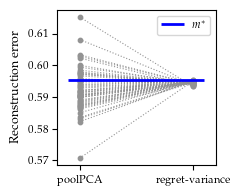

In [580]:
for name, v in {
    'norm-minPCA': vminpca1,
    'minPCA': vminpca2,
    'maxRCS': minpca3,
    'norm-regret-variance': minpca4,
    'regret-variance': minpca5,
}.items():
    out = []
    for i, test_cov in enumerate(test_covs1):
        params = generate_params([test_cov], from_cov=True)
        out.append({
            'var_pool': get_vars_pca(vpca1, params)[0],
            'var_minpca':  get_vars_pca(v, params)[0],
            'i': i,
        })
    out_df = pd.DataFrame(out)

    plt.figure(figsize=(2.4,2))
    for row in out_df.itertuples():
        plt.scatter(
                # [r'$\mathtt{PCA}$', r'$\mathtt{norm-maxRCS}$'], 
                ['poolPCA', name],
                [1-row.var_pool, 1-row.var_minpca], 
                s=10,
                marker='o', c='#939393')
        plt.plot(
            # [r'$\mathtt{PCA}$', r'$\mathtt{norm-maxRCS}$'], 
            ['poolPCA', name],
                [1-row.var_pool, 1-row.var_minpca], 
                ':', linewidth=0.8, #alpha=0.8,
                c='#939393')
    plt.hlines(1-minpca1.minvar(), xmin=-0.1, xmax=1.1, linestyle='-',
            linewidth=2,
            color='blue', label = r'$m^*$')
    plt.ylabel('Reconstruction error')
    plt.legend(loc='upper right')
    plt.xlim(-0.2, 1.2)
    plt.tight_layout()
    # plt.savefig('figs/sim_maxrcs_bound.png', dpi=400)
    plt.show()

## 1.5. boxplot

In [581]:
out_df_long= out_df.melt(id_vars=['i'], value_vars=['var_pool', 'var_minpca'],
                         var_name='method', value_name='value')
out_df_long['value']= (1-out_df_long['value'] )*100
out_df_long.head()

,i,method,value
0,0,var_pool,61.525697
1,1,var_pool,60.229671
2,2,var_pool,58.783993
3,3,var_pool,57.062826
4,4,var_pool,59.187734


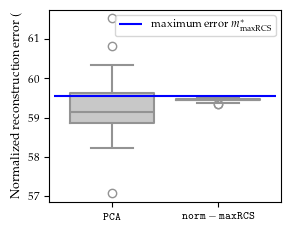

In [582]:
spec = dict(data=out_df_long, x='method', y='value', hue="method", 
            palette=['#939393', '#939393'])

sns.boxplot(**spec, linewidth=0, showfliers=False, boxprops=dict(alpha=.5))
sns.boxplot(**spec, fill=False, legend=False)

plt.hlines(100*(1-minpca1.minvar()), xmin=-0.55, xmax=1.55, linestyle='-',
           linewidth=1.5,
           color='blue', label = r'maximum error $m^*_\text{maxRCS}$')
plt.xticks(ticks=[0, 1], labels=[r'$\mathtt{PCA}$', r'$\mathtt{norm-maxRCS}$'])
plt.xlabel('')
plt.ylabel('Normalized reconstruction error (%)')
plt.legend()
plt.xlim(-0.6, 1.6)
plt.show()

## 1.6. distr of explained variances

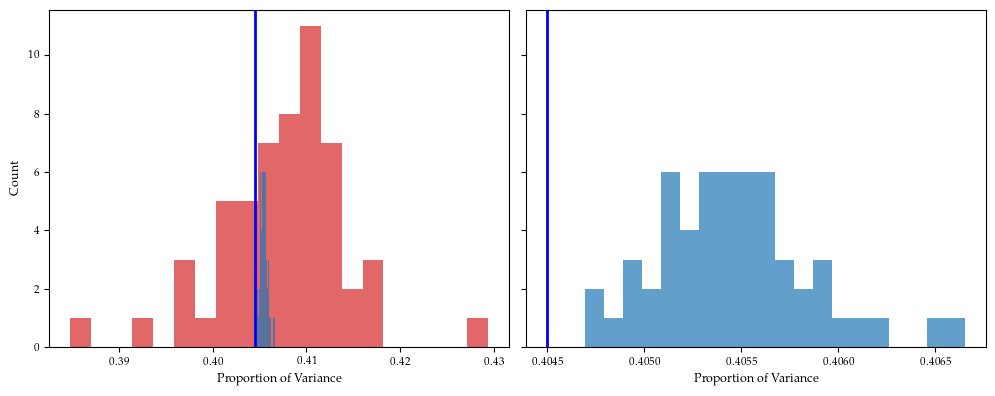

In [583]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].hist(out_df.var_pool, bins=20, color='tab:red', alpha=0.7)
axes[0].hist(out_df.var_minpca, bins=20, color='tab:blue', alpha=0.7)
axes[0].set_xlabel('Proportion of Variance')
axes[0].set_ylabel('Count')
axes[0].axvline(minpca1.minvar(), linestyle='-', linewidth=2, color='blue',
                label='minimum % explained variance')

axes[1].hist(out_df.var_minpca, bins=20, color='tab:blue', alpha=0.7)
axes[1].set_xlabel('Proportion of Variance')
axes[1].axvline(minpca1.minvar(), linestyle='-', linewidth=2, color='blue',
                label='minimum % explained variance')

plt.tight_layout()

# 2. How much do you lose on avg vs in the worst case?

## 2.1. run sim

In [596]:
SEED2 = 2

In [597]:
np.random.seed(SEED2)
torch.manual_seed(SEED2)

p2 = p1
n_components2 = n_components1
n_envs2 = n_envs1

In [598]:
out2 = []
for a,b in [(0.05, 0.1), (0.1, 0.5), (0.5, 1), (1, 5)]:
    for i in range(25):
        covs = get_random_covs(p2, n_components2, n_envs2,
                                 a1=0.5, b1=1.0, a2=a, b2=b, 
                                 full_cov=True)
        avg_cov = np.mean(covs, axis=0)
        res = avg_vs_wc(n_components2, avg_cov, covs)
        for r in res:
            r['a'] = a
            r['b'] = b
            r['i'] = i
        out2 += res

out_df2 = pd.DataFrame(out2)
out_df2.head()

	improving from 0.494 to 0.495
	improving from 0.495 to 0.497
	improving from 0.497 to 0.497
	improving from 0.476 to 0.476
	improving from 0.476 to 0.477
	improving from 0.505 to 0.505
	improving from 0.485 to 0.486
	improving from 0.499 to 0.499
	improving from 0.499 to 0.499
	improving from 0.496 to 0.497
	improving from 0.497 to 0.497
	improving from 0.497 to 0.498
	improving from 0.492 to 0.494
	improving from 0.494 to 0.495
	improving from 0.495 to 0.495
	improving from 0.495 to 0.497
	improving from 0.487 to 0.492
	improving from 0.492 to 0.493
	improving from 0.493 to 0.494
	improving from 0.476 to 0.479
	improving from 0.479 to 0.480
	improving from 0.470 to 0.470
	improving from 0.490 to 0.491
	improving from 0.491 to 0.491
	improving from 0.491 to 0.493
	improving from 0.493 to 0.493
	improving from 0.493 to 0.495
	improving from 0.495 to 0.496
	improving from 0.498 to 0.502
	improving from 0.480 to 0.483
	improving from 0.488 to 0.489
	improving from 0.489 to 0.489
	improvi

,metric,value,pca,minpca,a,b,i
0,$\Delta$ average,-0.008378,0.508504,0.500126,0.05,0.1,0
1,$\Delta$ worst-case,0.104320,0.393145,0.497466,0.05,0.1,0
2,$\Delta$ average,-0.004383,0.483057,0.478674,0.05,0.1,1
3,$\Delta$ worst-case,0.045869,0.430900,0.476770,0.05,0.1,1
4,$\Delta$ average,-0.002389,0.509199,0.506809,0.05,0.1,2


In [599]:
filename = 'results/minpca_pca_comparison_avg_vs_wc_1024.csv'

In [600]:
out_df2 = pd.DataFrame(out2)
out_df2.to_csv(filename, index=False)

In [ ]:
# out_df2 = pd.read_csv(filename)

`out_df2` has columns:
* `metric`: avg/worst-case
* `value`: diff minpca_var - pca_var (in `metric` case) (>0 => minPCA better) 
    
    (HENCE: `-value` gives the difference in RCS error where <0 => minPCA better)
* `pca`: gives the `metric` case expl variance of PCA
* `minpca`: as above

In [ ]:
out_df2.head()

,metric,value,pca,minpca,a,b,i
0,$\Delta$ average,-0.008378,0.508504,0.500126,0.05,0.1,0
1,$\Delta$ worst-case,0.104320,0.393145,0.497466,0.05,0.1,0
2,$\Delta$ average,-0.004383,0.483057,0.478674,0.05,0.1,1
3,$\Delta$ worst-case,0.045869,0.430900,0.476770,0.05,0.1,1
4,$\Delta$ average,-0.002389,0.509199,0.506809,0.05,0.1,2


## 2.2. plot

In [649]:
def plot_avg_vs_wc(df, column,s=10,
                   cmap_points=None,
                   cmap_lines=None,
                   ax=None,
                   ylabel=r'$\Delta$ normalized reconstruction error'):
    mmax = df[column].max()
    mmin = df[column].min()
    mmax = max(abs(mmax), abs(mmin))
    if cmap_lines is None:
        cmap_lines = {a: '#939393' for a in df['a'].unique()}

    show = ax is None
    if ax is None:
        fig, ax = plt.subplots() #figsize=(5, 5)

    # lines
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
    for i in range(len(df) // 2):
        delta_pool = df.iloc[i*2][column]
        delta_wc = df.iloc[i*2 + 1][column]
        ax.plot([r'$\Delta$ average', r'$\Delta$ worst-case'], 
                [-delta_pool, -delta_wc], 
                ':', linewidth=0.8, 
                zorder=1,
                c=cmap_lines[df.iloc[i*2]['a']])
        
    # Scatter plot
    if cmap_points is None:
        if column in ['rel_diff', 'value']:
            cmap = mcolors.LinearSegmentedColormap.from_list(
                'custom',
                ['tab:green', '#939393', 'tab:red']
            )
        elif column == 'rel_var':
            cmap = mcolors.LinearSegmentedColormap.from_list(
                'custom',
                ['tab:red', '#939393', 'tab:green']
            )
        else:
            raise NotImplementedError
        norm = mcolors.TwoSlopeNorm(vmin=-mmax, vcenter=0, vmax=mmax)
        
        sc = ax.scatter(x=df['metric'], y=-df[column], c=-df[column],
                        cmap=cmap, norm=norm, zorder=10, s=s)
        
        # Color each y-tick label according to the colormap
        yticks = ax.get_yticks()
        ax.set_yticks(yticks)  
        for tick_val, tick_label in zip(yticks, ax.get_yticklabels()):
            color = cmap(norm(tick_val))
            tick_label.set_color(color)
    else:
        # sc = ax.scatter(x=df['metric'], y=-df[column], c=-df[column],
        #                 hue=df['b'], palette=cmap_points, zorder=10)
        sc = sns.scatterplot(x=df['metric'], y=-df[column], 
                             hue=df['b'], palette=cmap_points, linewidth=0, s=s,
                            #  alpha=0.8, 
                             ax=ax, legend=False, zorder=10)

    ax.set_xlim(-0.2, 1.2)
    ax.set_ylabel(ylabel)
    if show: plt.show()

In [637]:
# Note:
# out_df2_supp.iloc[i*2]['pca'] -> gives the avg expl variance of PCA
# out_df2_supp.iloc[i*2+1]['pca'] -> gives the wc expl variance of PCA

out_df2_supp = out_df2.copy()
norm_diff = []
for i in range(len(out_df2_supp) // 2):
    nd1 = out_df2_supp.iloc[i*2]['value'] / (1-out_df2_supp.iloc[i*2]['pca']) * 100
    nd2 = out_df2_supp.iloc[i*2 + 1]['value'] / (1-out_df2_supp.iloc[i*2]['pca']) * 100
    norm_diff += [nd1, nd2]
out_df2_supp['rel_diff'] = norm_diff
out_df2_supp['rel_var'] = - np.array(norm_diff)

In [633]:
out_df2_supp.head()

,metric,value,pca,minpca,a,b,i,norm_diff,norm_var
0,$\Delta$ average,-0.008378,0.508504,0.500126,0.05,0.1,0,-1.704572,1.704572
1,$\Delta$ worst-case,0.104320,0.393145,0.497466,0.05,0.1,0,21.225070,-21.225070
2,$\Delta$ average,-0.004383,0.483057,0.478674,0.05,0.1,1,-0.847961,0.847961
3,$\Delta$ worst-case,0.045869,0.430900,0.476770,0.05,0.1,1,8.873222,-8.873222
4,$\Delta$ average,-0.002389,0.509199,0.506809,0.05,0.1,2,-0.486818,0.486818


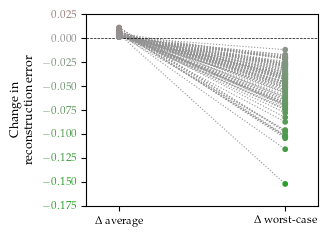

In [646]:
# absolute differences
plot_avg_vs_wc(out_df2, 'value', 
               ylabel='Change in\nreconstruction error')

<>:4: SyntaxWarning: invalid escape sequence '\%'
<>:4: SyntaxWarning: invalid escape sequence '\%'
/var/folders/dr/1jz7srgn1qjc7tmz515w0k5h00l95t/T/ipykernel_26145/980483609.py:4: SyntaxWarning: invalid escape sequence '\%'
  ylabel='Relative change in\nreconstruction error (\%)')


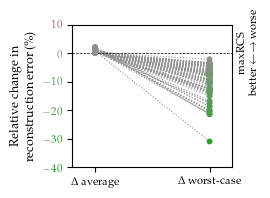

In [647]:
# relative differences
fig, ax = plt.subplots(figsize=(2.8,2))
plot_avg_vs_wc(out_df2_supp, 'rel_diff', s=10, ax=ax,
               ylabel='Relative change in\nreconstruction error (\%)')
ax.text(1.1, 0, 'maxRCS\nbetter ←→ worse',
        transform=ax.get_yaxis_transform(),  # x in axes coords, y in data coords
        rotation=90, va='center', ha='center', fontsize=8)
plt.tight_layout()
plt.savefig('figs_1026/sim_wc_vs_avg_rg.png', dpi=400)
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\%'
<>:4: SyntaxWarning: invalid escape sequence '\%'
/var/folders/dr/1jz7srgn1qjc7tmz515w0k5h00l95t/T/ipykernel_26145/132443567.py:4: SyntaxWarning: invalid escape sequence '\%'
  ylabel='Relative change in\nexplained variance (\%)')


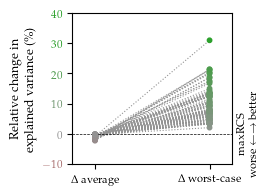

In [652]:
# relative differences
fig, ax = plt.subplots(figsize=(2.8,2))
plot_avg_vs_wc(out_df2_supp, 'rel_var', s=10, ax=ax,
               ylabel='Relative change in\nexplained variance (\%)')
ax.text(1.1, 0, 'maxRCS\nworse ←→ better',
        transform=ax.get_yaxis_transform(),  # x in axes coords, y in data coords
        rotation=90, va='center', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

## 2.3. plot as a function of 'heterogeneity'

In [657]:
colors = sns.color_palette("blend:#EDA,#7AB", len(out_df2['a'].unique()))
color_map = {a: colors[i] for i, a in enumerate(out_df2['a'].unique())}

### absolute

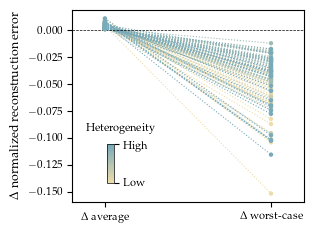

In [658]:
# absolute differences
fig, ax = plt.subplots()
plot_avg_vs_wc(out_df2, 'value', cmap_points=colors, ax=ax,
               cmap_lines=color_map)
ax.set_xlabel('')

cmap = mpl.colors.LinearSegmentedColormap.from_list('het', ['#EDA', '#7AB'])
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm   = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
axins = inset_axes(ax,
        width="3%",    # width 3% of ax[2]
        height="20%",  # height 30% of ax[2]
        loc='lower left',
        bbox_to_anchor=(0.15,0.1,1,1), #(1.05, 0.5, 1, 1),
        bbox_transform=ax.transAxes,
        borderpad=0)

cbar = fig.colorbar(sm, cax=axins, orientation='vertical')
# cbar.set_label('Heterogeneity', labelpad=-50)
cbar.ax.set_title('Heterogeneity', rotation=0, pad=10, x=2, fontsize=8)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Low', 'High'])
cbar.outline.set_linewidth(0.5)  # thinner box
plt.show()

### relative

<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:5: SyntaxWarning: invalid escape sequence '\%'
/var/folders/dr/1jz7srgn1qjc7tmz515w0k5h00l95t/T/ipykernel_26145/2643587547.py:5: SyntaxWarning: invalid escape sequence '\%'
  ylabel='Relative change in\nreconstruction error (\%)')
/var/folders/dr/1jz7srgn1qjc7tmz515w0k5h00l95t/T/ipykernel_26145/2643587547.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


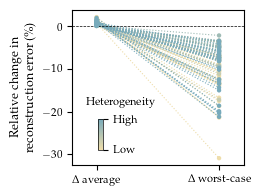

In [659]:
# absolute differences
fig, ax = plt.subplots(figsize=(2.6,2))
plot_avg_vs_wc(out_df2_supp, 'rel_diff', cmap_points=colors, ax=ax,
               cmap_lines=color_map, s=10,
               ylabel='Relative change in\nreconstruction error (\%)')
ax.set_xlabel('')

cmap = mpl.colors.LinearSegmentedColormap.from_list('het', ['#EDA', '#7AB'])
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm   = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
axins = inset_axes(ax,
        width="3%",    # width 3% of ax[2]
        height="20%",  # height 30% of ax[2]
        loc='lower left',
        bbox_to_anchor=(0.15,0.1,1,1), #(1.05, 0.5, 1, 1),
        bbox_transform=ax.transAxes,
        borderpad=0)

cbar = fig.colorbar(sm, cax=axins, orientation='vertical')
# cbar.set_label('Heterogeneity', labelpad=-50)
cbar.ax.set_title('Heterogeneity', rotation=0, pad=10, x=4.5, fontsize=8)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Low', 'High'], fontsize=8)
cbar.outline.set_linewidth(0.5)  # thinner box
plt.tight_layout()
plt.show()

R2 = -0.03


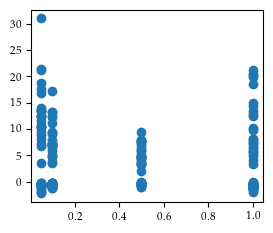

In [661]:
plt.scatter(out_df2_supp['a'], out_df2_supp['rel_diff'])
print(f"R2 = {np.corrcoef(out_df2_supp['a'], out_df2_supp['rel_diff'])[0,1]:.2f}")

## 2.4. distribution of wc/pooled expl var

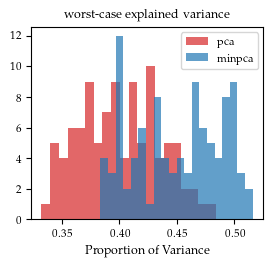

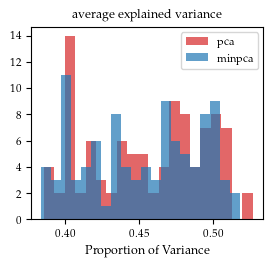

In [662]:
wc_df = out_df2[out_df2['metric'] == r'$\Delta$ worst-case']
pool_df = out_df2[out_df2['metric'] == r'$\Delta$ average']

plt.hist(wc_df['pca'], bins=20, color='tab:red', alpha=0.7, label='pca')
plt.hist(wc_df['minpca'], bins=20, color='tab:blue', alpha=0.7, label='minpca')
plt.title("worst-case explained variance")
plt.legend()
plt.xlabel('Proportion of Variance')
plt.show()

plt.hist(pool_df['pca'], bins=20, color='tab:red', alpha=0.7, label='pca')
plt.hist(pool_df['minpca'], bins=20, color='tab:blue', alpha=0.7, label='minpca')
plt.title("average explained variance")
plt.legend()
plt.xlabel('Proportion of Variance')
plt.show()

# 3. Finite-sample results

In [606]:
SEED3 = 2

np.random.seed(SEED3)
torch.manual_seed(SEED3)

# different sample sizes
sample_sizes = [100, 250, 500, 1000, 2000, 5000, 10000] # 
n_components3 = 5
n_components3_test = 5
nsims3 = 25
p3 = 20

## 3.1. run sim

In [607]:
def run_simulation(sample_size, training_covs, test_covs, n_components,
                   sample_size_test=None, verbose=True):
    if verbose:
        print(f'Running for n={sample_size}')

    p = training_covs[0].shape[0]  # number of features
    mu = np.zeros(p)  # mean vector

    # generate training data
    Xs = [np.random.multivariate_normal(mu, cov, sample_size) for cov in training_covs]
    X_pool = np.vstack(Xs)

    covs = [np.cov(X.T) for X in Xs]
    cov_pool = np.cov(X_pool.T)

    # generate test data
    if sample_size_test is None:
        sample_size_test = sample_size  # use same sample size for test data
    if sample_size_test < np.inf:
        Xs_test = [np.random.multivariate_normal(mu, cov, sample_size) 
                for cov in test_covs] 
        # Xs_test = [X - X.mean(axis=0) for X in Xs_test]
        X_test_pool = np.vstack(Xs_test)  
        covs_test = [np.cov(X.T) for X in Xs_test]
        cov_test_pool = np.cov(X_test_pool.T) 
    
    # fit PCA
    # pca = PCA(n_components=n_components)
    # pca.fit(X_pool)
    # vpca = torch.tensor(pca.components_.T, dtype=torch.float32)  
    
    # svd of the average covariance (ie population poolPCA solution)
    U1, S1, V1_T = np.linalg.svd(cov_pool)
    vpca = torch.tensor(V1_T.T[:, :n_components1]).float()

    # fit minPCA
    minpca = minPCA(n_components=n_components, norm=True) 
    minpca = minpca.fit(covs,  n_restarts=10, lr=0.5, n_iters=1000, from_cov=True) 
    vminpca = minpca.v_ #.detach().numpy()

    # error on test data
    out = []
    for v, method in zip([vpca, vminpca], [r'$\mathtt{PCA}$', r'$\mathtt{norm-minPCA}$']):
        for distr in ['in-dist', 'ood']:
            if distr == 'in-dist':
                params = generate_params(Xs)
                params_pooled = generate_params([X_pool])
            else:
                if sample_size_test < np.inf:
                    params = generate_params(Xs_test)
                    params_pooled = generate_params([X_test_pool])
                else:
                    params = generate_params(test_covs, from_cov=True)
                    params_pooled = generate_params([np.mean(test_covs, axis=0)], 
                                                    from_cov=True)

            # err_wc, err_pool = get_errs_pca(v, params, params_pooled)
            var_wc, var_pool = get_vars_pca(v, params, params_pooled)

            # save results
            out.append({
                'n': sample_size,
                # 'err_wc': err_wc,
                # 'err_pool': err_pool,
                'var_wc': var_wc,
                'var_pool': var_pool,
                'Method': method,
                'distr': distr,
            })

    return out

In [608]:
out_ss = []
for a,b in [(0.05, 0.1), (0.1, 0.5), (0.5, 1), (1, 5)]:
    for i in range(nsims3):
        training_covs_i = get_random_covs(p=p3, rank=n_components3, nenvs=5,
                                            a1=0.1, b1=1.0, a2=a, b2=b,
                                            full_cov=True)
        avg_cov_i = np.mean(training_covs_i, axis=0)
        
        # population results
        U, S, V_T = np.linalg.svd(avg_cov_i)
        vpca = torch.tensor(V_T.T[:, :n_components3_test]).float()

        minpca = minPCA(n_components=n_components3_test, norm=True) 
        minpca = minpca.fit(training_covs_i, from_cov=True, 
                            n_restarts=10, lr=0.1, n_iters=100) 
        vminpca = minpca.v_ 

        params = generate_params(training_covs_i, from_cov=True)
        params_pooled = generate_params([avg_cov_i], from_cov=True)

        var_wc_pca, var_pool_pca = get_vars_pca(vpca, params, params_pooled)
        var_wc_minpca, var_pool_minpca = get_vars_pca(vminpca, params, params_pooled)

        for n in sample_sizes:
            res_i = run_simulation(n, training_covs_i, training_covs_i, 
                                   n_components3_test, 
                                   sample_size_test=np.inf, 
                                   verbose=True)
            
            for r in res_i:
                r['sim'] = i
                r['a'] = a
                r['b'] = b
                if r['Method'] == r'$\mathtt{PCA}$':
                    r['var_wc_pop'] = var_wc_pca
                    r['var_pool_pop'] = var_pool_pca
                else:
                    r['var_wc_pop'] = var_wc_minpca
                    r['var_pool_pop'] = var_pool_minpca
            out_ss += res_i

out_df_ss = pd.DataFrame(out_ss)

	improving from 0.481 to 0.494
	improving from 0.494 to 0.495
	improving from 0.495 to 0.499
Running for n=100
	improving from 0.520 to 0.522
Running for n=250
	improving from 0.509 to 0.510
	improving from 0.510 to 0.510
Running for n=500
	improving from 0.508 to 0.511
Running for n=1000
	improving from 0.503 to 0.504
	improving from 0.504 to 0.505
	improving from 0.505 to 0.507
Running for n=2000
	improving from 0.499 to 0.500
	improving from 0.500 to 0.500
	improving from 0.500 to 0.501
Running for n=5000
	improving from 0.502 to 0.502
	improving from 0.502 to 0.503
Running for n=10000
	improving from 0.498 to 0.500
	improving from 0.500 to 0.501
	improving from 0.501 to 0.504
	improving from 0.457 to 0.466
	improving from 0.466 to 0.471
	improving from 0.471 to 0.471
Running for n=100
	improving from 0.494 to 0.496
Running for n=250
	improving from 0.474 to 0.475
	improving from 0.475 to 0.478
Running for n=500
	improving from 0.479 to 0.481
Running for n=1000
	improving from 0.474

In [609]:
filename = 'results/minpca_pca_comparison_ntest_same_ntrain_etest_is_etrain_manyDG_1024.csv'

In [ ]:
# out_df_ss.to_csv(filename, index=False)

In [ ]:
out_df_ss = pd.read_csv(filename)

In [260]:
out_df_ss.head()

,n,var_wc,var_pool,Method,distr,sim,a,b,var_wc_pop,var_pool_pop
0,100,0.899619,0.915200,$\mathtt{PCA}$,in-dist,0,0.05,0.1,0.902781,0.911716
1,100,0.901692,0.910625,$\mathtt{PCA}$,ood,0,0.05,0.1,0.902781,0.911716
2,100,0.907239,0.911149,$\mathtt{norm-minPCA}$,in-dist,0,0.05,0.1,0.905577,0.909146
3,100,0.901322,0.905683,$\mathtt{norm-minPCA}$,ood,0,0.05,0.1,0.905577,0.909146
4,250,0.908451,0.913378,$\mathtt{PCA}$,in-dist,0,0.05,0.1,0.902781,0.911716


## distr of expl variance

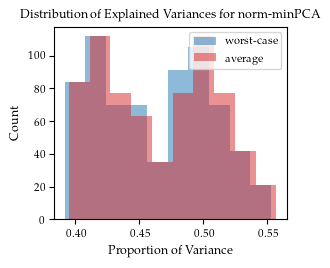

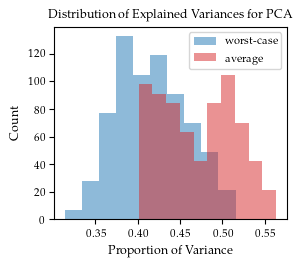

In [663]:
testdf = out_df_ss[out_df_ss['distr'] == 'in-dist']
# testdf = testdf[testdf['sim'] == 0]
testdf = testdf[testdf['Method'] == r'$\mathtt{norm-minPCA}$']
plt.hist(testdf['var_wc_pop'], color='tab:blue', alpha=0.5, label='worst-case')
plt.hist(testdf['var_pool_pop'], color='tab:red', alpha=0.5, label='average')
plt.xlabel('Proportion of Variance')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Explained Variances for norm-minPCA')
plt.show()

testdf = out_df_ss[out_df_ss['distr'] == 'in-dist']
# testdf = testdf[testdf['sim'] == 0]
testdf = testdf[testdf['Method'] == r'$\mathtt{PCA}$']
plt.hist(testdf['var_wc_pop'], color='tab:blue', alpha=0.5, label='worst-case')
plt.hist(testdf['var_pool_pop'], color='tab:red', alpha=0.5, label='average')
plt.xlabel('Proportion of Variance')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Explained Variances for PCA')
plt.show()

## helper

In [664]:
def plot_finite_sample_convergence(df, distr='in-dist', relative=False, fig=None, ax=None, 
                                   loc='lower right', variance=False,
                                   minn=None, ylim=None, ms=40, fancy_cmap=True,
                                   maxn=None, alpha=0.5, ylabel='', title='', both=False):
    if minn is not None:
        df = df[df['n'] >= minn].copy()
    if maxn is not None:
        df = df[df['n'] <= maxn].copy()

    show = False
    if ax is None: 
         fig, ax = plt.subplots(figsize=(6, 5))
         show = True

    if fancy_cmap:
        colors = sns.color_palette("blend:#EDA,#7AB", len(df['a'].unique()))
    else: 
        colors = ['#7AB' for _ in range(len(df['a'].unique()))]

    for i in df['sim'].unique():
        for j, a in enumerate(df['a'].unique()):
                dfi = df[(df['sim'] == i) & (df['distr'] == distr) &
                         (df['a'] == a)]
                dfi_pool = dfi[dfi['Method'] == r'$\mathtt{PCA}$']
                dfi_minpca = dfi[dfi['Method'] == r'$\mathtt{norm-minPCA}$']

                if relative:
                    if variance:
                        relative_gain = dfi_minpca['var_wc'].values - dfi_pool['var_wc'].values
                        # relative_gain /= (dfi_pool['var_wc_pop'].values)
                    else:
                        relative_gain = - dfi_minpca['var_wc'].values + dfi_pool['var_wc'].values
                        # relative_gain /= (1-dfi_pool['var_wc_pop'].values)
                    # relative_gain *= 100

                    # if variance:
                    #     relative_gain = dfi_minpca['var_wc'].values / dfi_pool['var_wc'].values
                    # else:
                    #     relative_gain = dfi_minpca['err_wc'].values / dfi_pool['err_wc'].values

                    ax.plot(dfi_pool['n'], relative_gain, alpha=alpha,
                            c=colors[j], ms=ms,
                            marker='o')
                else:
                    if both:
                        ax.plot(dfi_pool['n'], 
                                ((1-dfi_pool['var_wc'].values) - (1-dfi_minpca['var_wc_pop'].values)) /  (1-dfi_minpca['var_wc_pop'].values),
                                marker='o', ms=ms, c='tab:red', alpha=alpha, label=r'$\mathtt{PCA}$')
                    col = 'tab:blue' if both or fancy_cmap else '#7AB'
                    ax.plot(dfi_minpca['n'], 
                            # ((1-dfi_minpca['var_wc']) - (1-dfi_minpca['var_wc_pop'])) / (1-dfi_minpca['var_wc_pop']),
                            ((1-dfi_minpca['var_wc']) - (1-dfi_minpca['var_wc_pop'])),
                            marker='o', ms=ms, c=col, alpha=alpha, label=r'$\mathtt{norm-minPCA}$')
                    # sns.lineplot(data=dfi, x='n', y='var_wc', hue='Method', ax=ax)
                    if both: 
                         plt.legend(title='Method', loc='upper right')

    hline = 0 #if relative else 1
    # hline = 1
    ax.axhline(hline, color='black', linestyle='--', linewidth=0.5)
    ax.set(xlabel='Sample size', ylabel=ylabel, title=title)

    if relative and fancy_cmap:
        cmap = mpl.colors.LinearSegmentedColormap.from_list('het', ['#EDA', '#7AB'])
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        sm   = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])

        # if lower right inset
        if loc == 'lower right':
            axins = inset_axes(ax,
                    width="3%",    # width 3% of ax[2]
                    height="20%",  # height 30% of ax[2]
                    loc='lower right',
                    bbox_to_anchor=(0,0.05,0.8,0.88), #(1.05, 0.5, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)
        if loc == 'upper right':
            axins = inset_axes(ax,
                    width="3%",    # width 3% of ax[2]
                    height="20%",  # height 30% of ax[2]
                    loc='upper right',
                    bbox_to_anchor=(0,0,0.7,0.85), #(1.05, 0.5, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)
        
        cbar = fig.colorbar(sm, cax=axins, orientation='vertical')
        cbar.ax.set_title('Heterogeneity', rotation=0, pad=8, x=2, fontsize=8)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['Low', 'High'], fontsize=8)
        cbar.outline.set_linewidth(0.5)  # thinner box

    elif both:
         handles = [plt.Line2D([0], [0], color=c, marker='o', linestyle='-', label=lab) 
                    for c,lab in zip(['tab:red', 'tab:blue'], 
                                     [r'$\mathtt{PCA}$', r'$\mathtt{norm-minPCA}$'])]
         ax.legend(handles=handles, title='Method', loc='upper right')

    if ylim is not None:
        ax.set_ylim(ylim)

    # ax.set_xticks(dfi_pool['n'].unique())
    
    if show: 
         plt.show()

## plot fs convergence

In [665]:
out_df_ss.tail()


,n,var_wc,var_pool,Method,distr,sim,a,b,var_wc_pop,var_pool_pop
2795,5000,0.507516,0.512891,$\mathtt{norm-minPCA}$,ood,24,1.0,5.0,0.507415,0.511853
2796,10000,0.484399,0.518288,$\mathtt{PCA}$,in-dist,24,1.0,5.0,0.481399,0.517419
2797,10000,0.484375,0.517322,$\mathtt{PCA}$,ood,24,1.0,5.0,0.481399,0.517419
2798,10000,0.510377,0.514134,$\mathtt{norm-minPCA}$,in-dist,24,1.0,5.0,0.507415,0.511853
2799,10000,0.508467,0.512932,$\mathtt{norm-minPCA}$,ood,24,1.0,5.0,0.507415,0.511853


<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
/var/folders/dr/1jz7srgn1qjc7tmz515w0k5h00l95t/T/ipykernel_26145/4177363906.py:1: SyntaxWarning: invalid escape sequence '\%'
  ylab1 = 'Gain in worst-case\nexplained variance (\%)'
/var/folders/dr/1jz7srgn1qjc7tmz515w0k5h00l95t/T/ipykernel_26145/4177363906.py:2: SyntaxWarning: invalid escape sequence '\%'
  ylab2 = 'Decrease in worst-case\nreconstruction error (\%)'


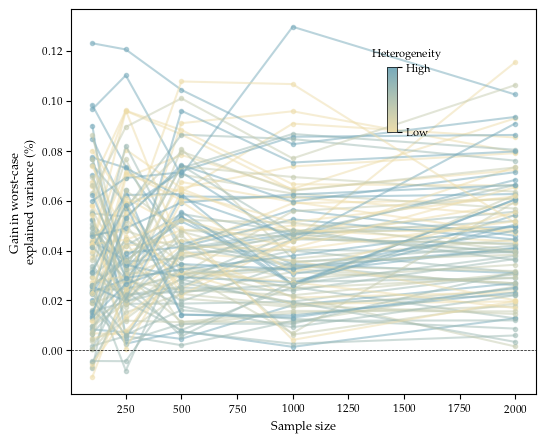

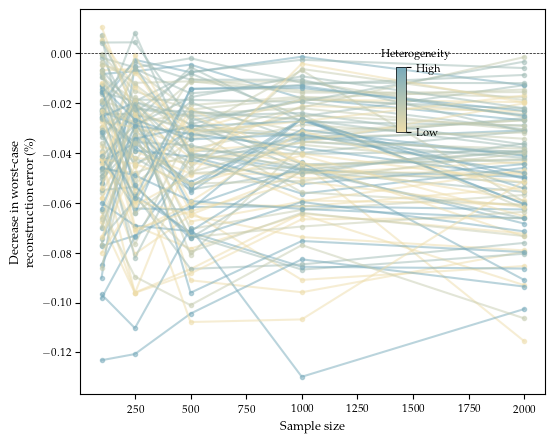

In [666]:
ylab1 = 'Gain in worst-case\nexplained variance (\%)'
ylab2 = 'Decrease in worst-case\nreconstruction error (\%)'
plot_finite_sample_convergence(out_df_ss, distr='ood', relative=True, #minn=100,
                               fancy_cmap=True,
                               loc = 'upper right', ms=3, #ylim=(-10, 55),
                               maxn=2000, ylabel=ylab1, variance=True)
plot_finite_sample_convergence(out_df_ss, distr='ood', relative=True,# minn=100,
                               loc = 'upper right', ms=3, #ylim=(-30, 30),
                               maxn=2000, ylabel=ylab2, variance=False)

<>:8: SyntaxWarning: invalid escape sequence '\ '
<>:15: SyntaxWarning: invalid escape sequence '\ '
<>:8: SyntaxWarning: invalid escape sequence '\ '
<>:15: SyntaxWarning: invalid escape sequence '\ '
/var/folders/dr/1jz7srgn1qjc7tmz515w0k5h00l95t/T/ipykernel_26145/2131681123.py:8: SyntaxWarning: invalid escape sequence '\ '
  title='Empirical maxRCS vs.\ \npopulation maxRCS')
/var/folders/dr/1jz7srgn1qjc7tmz515w0k5h00l95t/T/ipykernel_26145/2131681123.py:15: SyntaxWarning: invalid escape sequence '\ '
  title='Empirical maxRCS vs.\ \nempirical poolPCA')
/var/folders/dr/1jz7srgn1qjc7tmz515w0k5h00l95t/T/ipykernel_26145/2131681123.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


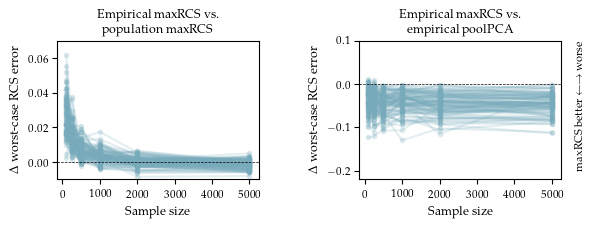

In [667]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 1.8), sharey=False,
                       # increase space between plots
                       gridspec_kw={'wspace':.5})

plot_finite_sample_convergence(out_df_ss, distr='ood', alpha=0.2, minn=100, ms=3,
                               maxn=5000, fancy_cmap=False, ax=ax[0], 
                               ylabel=r'$\Delta$ worst-case RCS error',
                               title='Empirical maxRCS vs.\ \npopulation maxRCS')

plot_finite_sample_convergence(out_df_ss, distr='ood', alpha=0.2, minn=100, ms=3,
                               maxn=5000, fancy_cmap=False, ax=ax[1],
                               relative=True, fig=fig, 
                               loc = 'upper right',
                               ylabel=r'$\Delta$ worst-case RCS error',
                               title='Empirical maxRCS vs.\ \nempirical poolPCA')

ax[1].text(1.07, 0, '→ worse',
        transform=ax[1].get_yaxis_transform(),  # x in axes coords, y in data coords
        rotation=90, va='bottom', ha='left', fontsize=8)
ax[1].text(1.07, 0, 'maxRCS better ←',
        transform=ax[1].get_yaxis_transform(),  # x in axes coords, y in data coords
        rotation=90, va='top', ha='left', fontsize=8)

ax[0].set_ylim(-0.01, 0.07)
ax[1].set_ylim(-.22, .1)
plt.tight_layout()
# plt.savefig('figs/sim_maxrcs_fs.png', bbox_inches='tight', dpi=600)
plt.show()

In [668]:
out_df_ss_wide_by_method = out_df_ss.\
    pivot_table(index=['sim', 'n', 'a', 'b', 'distr'],
                columns='Method',
                values=['var_wc', 'var_wc_pop', 'var_pool_pop']).reset_index()
# flatten the multi-level columns
out_df_ss_wide_by_method.columns = [
    '_'.join(col).strip() 
    if col[1] else col[0] 
    for col in out_df_ss_wide_by_method.columns.values
]
out_df_ss_wide_by_method.head()

difference_df = out_df_ss_wide_by_method.copy()
difference_df['var_wc_diff_vs_pop'] = difference_df['var_wc_$\\mathtt{norm-minPCA}$'] - difference_df['var_wc_pop_$\\mathtt{norm-minPCA}$']
difference_df['rcs_wc_diff_vs_pop'] = - difference_df['var_wc_diff_vs_pop']

difference_df['var_wc_diff_vs_pool'] = difference_df['var_wc_$\\mathtt{norm-minPCA}$'] - difference_df['var_wc_$\\mathtt{PCA}$']
difference_df['rcs_wc_diff_vs_pool'] = - difference_df['var_wc_diff_vs_pool']
difference_df.head()

,sim,n,a,b,distr,var_pool_pop_$\mathtt{PCA}$,var_pool_pop_$\mathtt{norm-minPCA}$,var_wc_$\mathtt{PCA}$,var_wc_$\mathtt{norm-minPCA}$,var_wc_pop_$\mathtt{PCA}$,var_wc_pop_$\mathtt{norm-minPCA}$,var_wc_diff_vs_pop,rcs_wc_diff_vs_pop,var_wc_diff_vs_pool,rcs_wc_diff_vs_pool
0,0,100,0.05,0.1,in-dist,0.505574,0.503557,0.479919,0.522172,0.472635,0.498665,0.023507,-0.023507,0.042253,-0.042253
1,0,100,0.05,0.1,ood,0.505574,0.503557,0.460422,0.472700,0.472635,0.498665,-0.025965,0.025965,0.012278,-0.012278
2,0,100,0.10,0.5,in-dist,0.447016,0.443309,0.375968,0.454100,0.422338,0.438816,0.015284,-0.015284,0.078131,-0.078131
3,0,100,0.10,0.5,ood,0.447016,0.443309,0.366808,0.422695,0.422338,0.438816,-0.016121,0.016121,0.055887,-0.055887
4,0,100,0.50,1.0,in-dist,0.410265,0.404344,0.400767,0.435659,0.368948,0.400194,0.035465,-0.035465,0.034892,-0.034892


<>:14: SyntaxWarning: invalid escape sequence '\ '
<>:25: SyntaxWarning: invalid escape sequence '\ '
<>:14: SyntaxWarning: invalid escape sequence '\ '
<>:25: SyntaxWarning: invalid escape sequence '\ '
/var/folders/dr/1jz7srgn1qjc7tmz515w0k5h00l95t/T/ipykernel_26145/1795748234.py:14: SyntaxWarning: invalid escape sequence '\ '
  ax[0].set_title('Empirical maxRCS vs.\ \npopulation maxRCS')
/var/folders/dr/1jz7srgn1qjc7tmz515w0k5h00l95t/T/ipykernel_26145/1795748234.py:25: SyntaxWarning: invalid escape sequence '\ '
  ax[1].set_title('Empirical maxRCS vs.\ \nempirical poolPCA')
/var/folders/dr/1jz7srgn1qjc7tmz515w0k5h00l95t/T/ipykernel_26145/1795748234.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


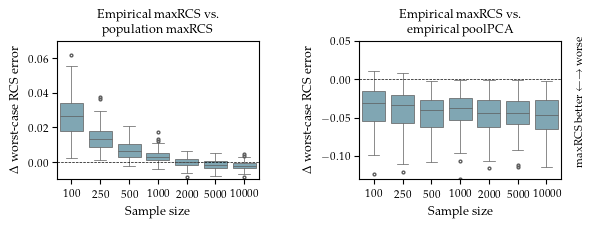

In [669]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 1.8), sharey=False,
                       # increase space between plots
                       gridspec_kw={'wspace':.5})

sns.boxplot(data=difference_df[difference_df['distr'] == 'ood'],
            ax=ax[0],
            x='n', y='rcs_wc_diff_vs_pop', #hue='Method',
            color='#7AB',
            fliersize=2,
            linewidth=0.5)
ax[0].axhline(0, color='black', linestyle='--', linewidth=0.5)
ax[0].set_ylabel(r'$\Delta$ worst-case RCS error')
ax[0].set_xlabel('Sample size')
ax[0].set_title('Empirical maxRCS vs.\ \npopulation maxRCS')

sns.boxplot(data=difference_df[difference_df['distr'] == 'ood'],
            ax=ax[1],
            x='n', y='rcs_wc_diff_vs_pool', #hue='Method',
            color='#7AB',
            fliersize=2,
            linewidth=0.5)
ax[1].axhline(0, color='black', linestyle='--', linewidth=0.5)
ax[1].set_ylabel(r'$\Delta$ worst-case RCS error')
ax[1].set_xlabel('Sample size')
ax[1].set_title('Empirical maxRCS vs.\ \nempirical poolPCA')

ax[1].text(1.07, 0, '→ worse',
        transform=ax[1].get_yaxis_transform(),  # x in axes coords, y in data coords
        rotation=90, va='bottom', ha='left', fontsize=8)
ax[1].text(1.07, 0, 'maxRCS better ←',
        transform=ax[1].get_yaxis_transform(),  # x in axes coords, y in data coords
        rotation=90, va='top', ha='left', fontsize=8)

ax[0].set_ylim(-0.01, 0.07)
ax[1].set_ylim(-.13, .05)

plt.tight_layout()
plt.savefig('figs_1026/sim_maxrcs_fs_box.png', dpi=600, bbox_inches='tight')
plt.show()

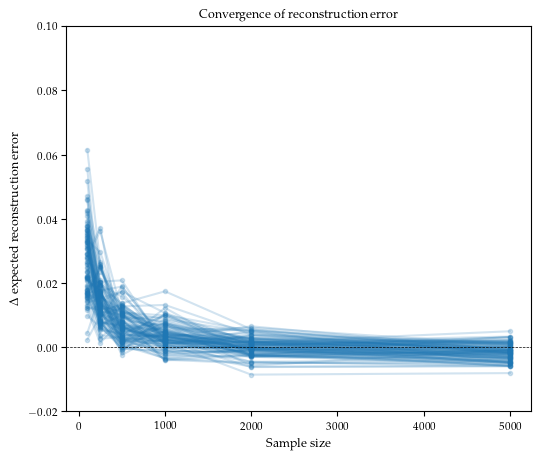

In [670]:
plot_finite_sample_convergence(out_df_ss, distr='ood', alpha=0.2, minn=100, maxn=5000, ms=3,
                            #    ax=ax[1],
                            #    ylabel=ylab2,
                               ylim =(-0.02, 0.1),
                               relative=False,
                               ylabel=r'$\Delta$ expected reconstruction error',
                               title=r'Convergence of reconstruction error')

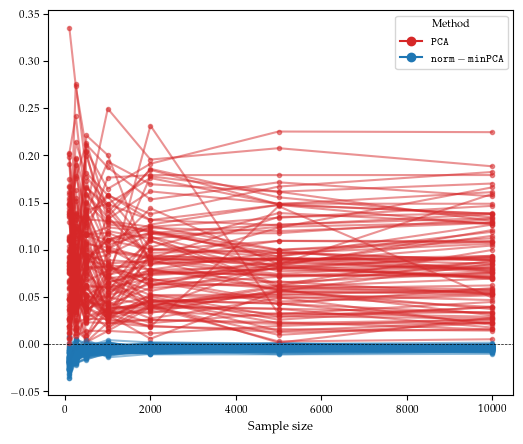

In [671]:
plot_finite_sample_convergence(out_df_ss, distr='in-dist', both=True, ms=3)

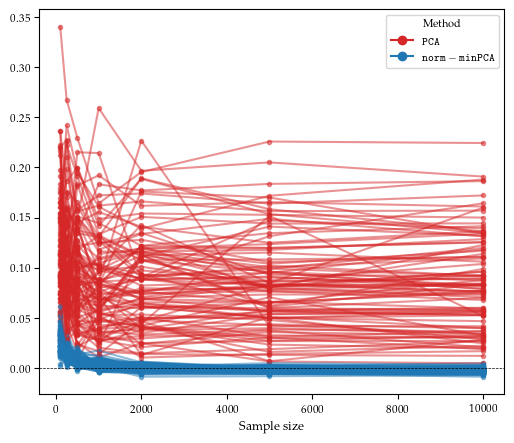

In [672]:
plot_finite_sample_convergence(out_df_ss, distr='ood', both=True, ms=3)